In [18]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [19]:
T = 0.005
s = ctl.TransferFunction.s

In [20]:
G = 0.025/(0.15560577*s**2 - 0.78893795*s + 1.0)
C = (5.1783*s + 23.3272)/(0.0352*s + 1.0) * (0.746704*s**2 + 75.3371*s + 66.67)/(0.00112*s**2 + 1.12*s)

G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([ 0.09666643, 10.18841546, 52.5660215 , 38.8806106 ]), array([6.13460188e-06, 6.27777725e-03, 2.38997619e-01, 9.34534896e+00,
       5.36860215e+01, 3.88806106e+01]))

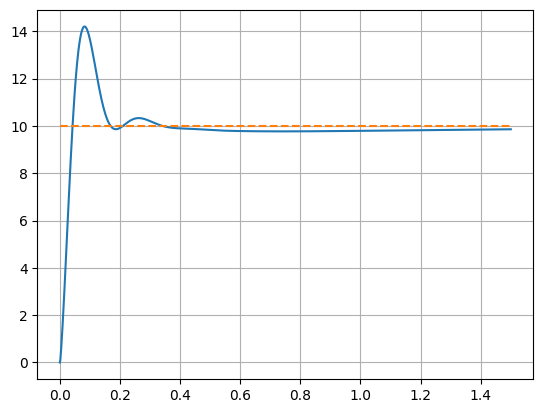

In [21]:
sp = 10

tData = np.linspace(0, 1.5, 1000)
uData = [sp for i in tData]
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)

plt.plot(time, response)
plt.plot(time, [sp for i in time], '--')
plt.grid()

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [22]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([2.02533155e-06, 2.04251849e-06]), array([ 1.        , -2.02551188,  1.02567459]), 0.005)

In [23]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([ 33147.4630214 , -85297.45513233,  71510.1893248 , -19358.88175987]), array([ 1.        , -1.43880258,  0.06707086,  0.37173172]), 0.005)

In [24]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([ 0.0671346 , -0.10505132, -0.02938979,  0.10685273, -0.03954087]), array([ 1.        , -3.39717985,  3.90200585, -1.26925414, -0.5773014 ,
        0.3417349 ]), 0.005)

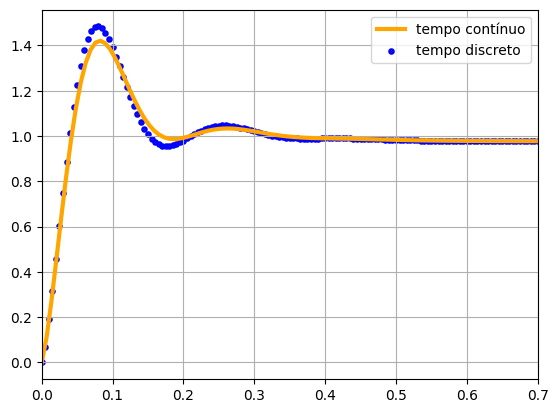

In [35]:
time, response = ctl.step_response(G_feedback)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

time, response = ctl.step_response(G_z_feedback)
plt.scatter(time, response, color='blue', linewidth=3, label='tempo discreto', s=3)

plt.xlim([0, .7])
plt.legend()
plt.grid()
plt.show()

# COMPARANDO A RESPOSTA DO CONTROLADOR

- Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada

In [26]:
num, den = ctl.tfdata(C_z)
num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

print(num)
print(den)

[ 33147.4630214  -85297.45513233  71510.1893248  -19358.88175987]
[ 1.         -1.43880258  0.06707086  0.37173172]


- Printando a saída de forma a ser entendida por uma máquina de baixo nível

In [27]:
out = ''

for i in range(0, len(num)):
    out += f'{num[i]}*X_n{i} + '

for i in range(1, len(den)):
    out += f'+ {-1*den[i]}*Y_n{i}'

out = out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')
print(out + ';')

33147.46302139862*X_n -85297.45513233077*X_n1 + 71510.18932479914*X_n2 -19358.881759873315*X_n3 + 1.4388025767336112*Y_n1-0.0670708601743083*Y_n2-0.37173171655930287*Y_n3;


- Resposta do controlador em feedback

In [28]:
Y_n1 = Y_n2 = Y_n3 = Y_n4 = 0
X_n1 = X_n2 = X_n3 = X_n4 = 0

def computeController(inputValue, setpoint):
    global Y_n1, Y_n2, Y_n3, Y_n4
    global X_n1, X_n2, X_n3, X_n4

    X_n =  setpoint - inputValue
    Y_n = eval(out)

    X_n4 = X_n3
    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n4 = Y_n3
    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

- Comparando os dados contínuo e digital de forma gráfica através de um step

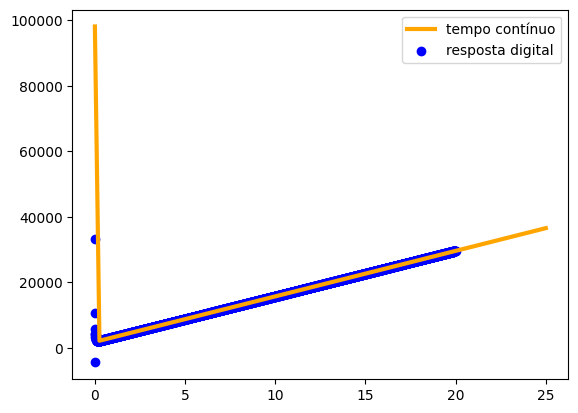

In [29]:
time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

Y_n1 = Y_n2 = Y_n3 = Y_n4 = 0
X_n1 = X_n2 = X_n3 = Y_n4 = 0

time     = np.arange(0, 20, T)
response = [computeController(1, 2) for i in time] # degrau (erro 1 é a entrada)
plt.scatter(time, response, color='blue', label='resposta digital')

plt.legend()
plt.show()

# TESTANDO A RESPOSTA
- Se o erro é positivo, o controlador atua aumentando a saída do sistema

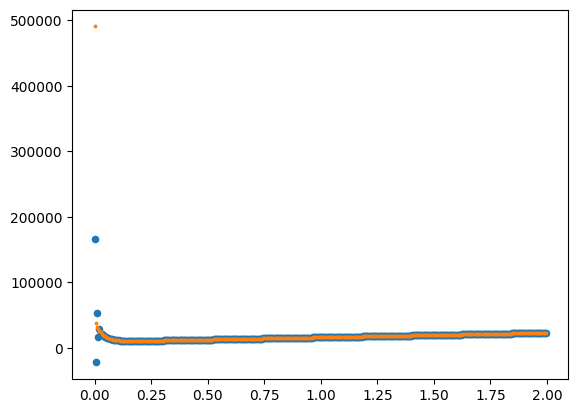

In [30]:
inputValue = 5
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response, s=20)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)

- Se o erro é negativo, o controlador atua diminuindo a saída do sistema

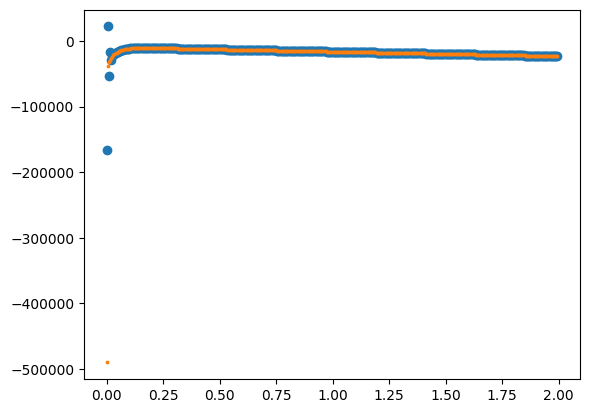

In [31]:
inputValue = 15
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)

- Se o erro é zero, o não atua e mantém a saída fixa

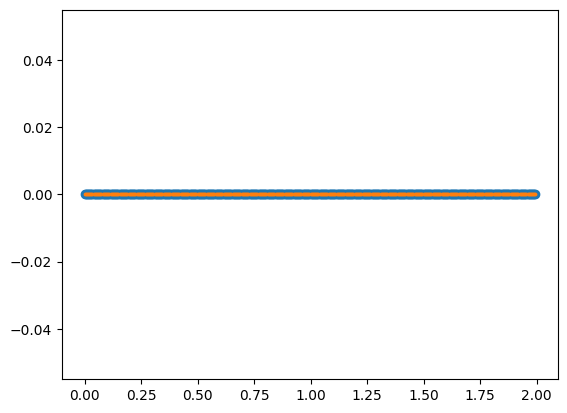

In [32]:
inputValue = 10
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)